In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import jax
import jax.numpy as jnp
from evosax import CMA_ES, SimAnneal

from envs.photon_env import BatchedPhotonLangevinReadoutEnv

In [8]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.05
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 5.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64
num_envs = 8
num_updates = 2000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [9]:
env = BatchedPhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    batchsize=batchsize,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight,
)

In [10]:
# Instantiate the search strategy
rng = jax.random.PRNGKey(0)
strategy = CMA_ES(popsize=batchsize, num_dims=env.num_actions, elite_ratio=0.6)
es_params = strategy.default_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu)
es_params

EvoParams(mu_eff=Array(16.98963432, dtype=float64), c_1=Array(0.00013356, dtype=float64), c_mu=Array(0.00198713, dtype=float64), c_sigma=Array(0.13280427, dtype=float64), d_sigma=Array(1.13280427, dtype=float64), c_c=Array(0.03304903, dtype=float64), chi_n=Array(10.9773085, dtype=float64, weak_type=True), c_m=1.0, sigma_init=1.0, init_min=-1, init_max=1, clip_min=-2.3255813953488373, clip_max=2.3255813953488373)

In [11]:
# Simulated Annealing

sim_anneal = SimAnneal(popsize=batchsize, num_dims=env.num_actions)
sim_params = sim_anneal.default_params
sim_params = sim_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu,)

In [12]:
def custom_rollout(batch_actions):
    res_drive = env.a0 * batch_actions.astype(jnp.float64)
    normalizing_factor = jnp.clip(
        env.mu * env.a0 / jnp.absolute(res_drive),
        0.0,
        1.0,
    )
    res_drive *= normalizing_factor
    res_drive = env.batched_smoother(res_drive)

    batch_res = env.batched_results(res_drive)
    reward, _ = env.batched_reward_and_state(
        batch_res.astype(env.float_dtype), res_drive
    )

    fitness = -reward # Since we are dealing with minimisation

    return fitness.astype(jnp.float32)

In [15]:
import time

strat = sim_anneal
params = sim_params

state = strat.initialize(rng, params)

start = time.time()
fitness_list = []

# Run ask-eval-tell loop - NOTE: By default minimization
for t in range(int(2e4)):
    rng, rng_gen, rng_eval = jax.random.split(rng, 3)
    x, state = strat.ask(rng_gen, state, params)
    fitness = custom_rollout(x)
    state = strat.tell(x, fitness, state, params)
    fitness_list.append(state.best_fitness)

    if (t + 1) % 100 == 0:
        # print("CMA-ES - # Gen: {}|Fitness: {:.5f}|Params: {}".format(
        #     t+1, state.best_fitness, state.best_member))
        print("CMA-ES - # Gen: {}|Fitness: {:.5f}".format(
            t+1, state.best_fitness))
        print(f"Time: {time.time() - start}")

CMA-ES - # Gen: 100|Fitness: 15.13249
Time: 1.8215758800506592
CMA-ES - # Gen: 200|Fitness: 7.25161
Time: 3.323089838027954
CMA-ES - # Gen: 300|Fitness: 0.43642
Time: 5.1059980392456055
CMA-ES - # Gen: 400|Fitness: 0.43642
Time: 6.820810794830322
CMA-ES - # Gen: 500|Fitness: 0.43642
Time: 8.330006837844849
CMA-ES - # Gen: 600|Fitness: -2.36536
Time: 9.791298866271973
CMA-ES - # Gen: 700|Fitness: -2.36536
Time: 11.223121881484985
CMA-ES - # Gen: 800|Fitness: -2.36536
Time: 12.70204472541809
CMA-ES - # Gen: 900|Fitness: -2.36536
Time: 14.443506717681885
CMA-ES - # Gen: 1000|Fitness: -2.42934
Time: 16.072117805480957
CMA-ES - # Gen: 1100|Fitness: -2.42934
Time: 17.503411769866943
CMA-ES - # Gen: 1200|Fitness: -2.42934
Time: 18.944056034088135
CMA-ES - # Gen: 1300|Fitness: -3.62204
Time: 20.41284680366516
CMA-ES - # Gen: 1400|Fitness: -3.62204
Time: 21.890955924987793
CMA-ES - # Gen: 1500|Fitness: -4.11706
Time: 23.316983938217163
CMA-ES - # Gen: 1600|Fitness: -4.11706
Time: 24.72803401947

KeyboardInterrupt: 

[-0.60087091  0.7959279   0.79447597  0.91270375  1.49215001  1.45339006
  1.52619544  2.06081705  1.16216035  1.52312334  1.16292185  1.91181106
  1.00143636  1.82077909  1.48336916  1.67124912  1.84723815  1.67279473
  1.98584108  1.70076598  1.60286732  1.85395922  1.50223593  1.89271467
  1.49999653  1.5091763   1.9941389   0.94538244  2.29580931  0.74277723
  2.26801807  1.16666777  1.38760715  1.63051309  0.3639849   1.84999337
  0.45310148  1.88355765  0.62647146  1.17250235  0.89760276  1.1460953
  0.96660337  0.91179558  1.35657699  1.20637505  1.42852232  1.32852211
  1.01160156  1.62348189  1.12959806  1.10078179  0.69727077  0.81912643
 -0.11683762  0.15125208 -0.71841438 -0.61665669 -1.14990539 -0.88889841
 -1.1646007  -1.07672407 -1.88169602 -1.06607603 -2.01282255 -1.34099979
 -1.51409047 -1.41975869 -0.90423779 -1.35973206 -1.1303735  -1.86992641
 -1.41703234 -2.20306115 -2.01035135 -1.89847519 -1.97428399 -1.26896952
 -1.79711259 -1.46392395 -1.16100781 -1.58004099 -0.

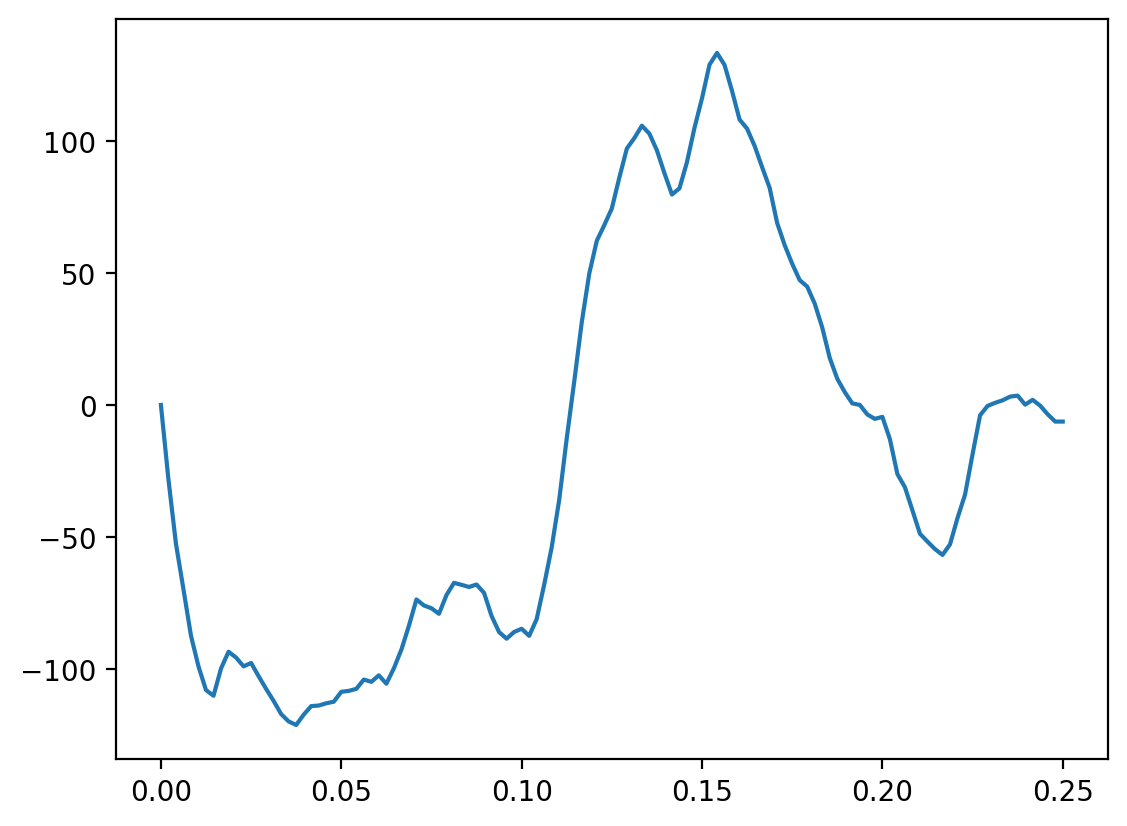

In [16]:
import matplotlib.pyplot as plt

action = state.best_member
action *= env.a0
action = -env.drive_smoother(action)

print(state.best_member)
plt.plot(env.ts_action, action)
plt.show()

In [17]:
batched_action = jnp.tile(action, (batchsize, 1))

batched_res = env.batched_results(batched_action)
(
    max_pf,
    max_photons,
    photon_reset_time,
    pulse_end_times,
    max_pf_times,
    smoothness_vals,
    b_pf,
    b_higher_photons,
    _
) = env.batched_extract_values(batched_res, batched_action)

reward, _ = env.batched_reward_and_state(
    batched_res,
    batched_action
)

print(max_pf_times[0])
print(photon_reset_time[0])
print(pulse_end_times[0])
print(reward[0])
print(max_pf[0])

0.12222222222222223
0.2319119278274101
0.23125
23.169595832992552
2.5553169383697076


0.05058697758511586
326
0.05058697758511586
326


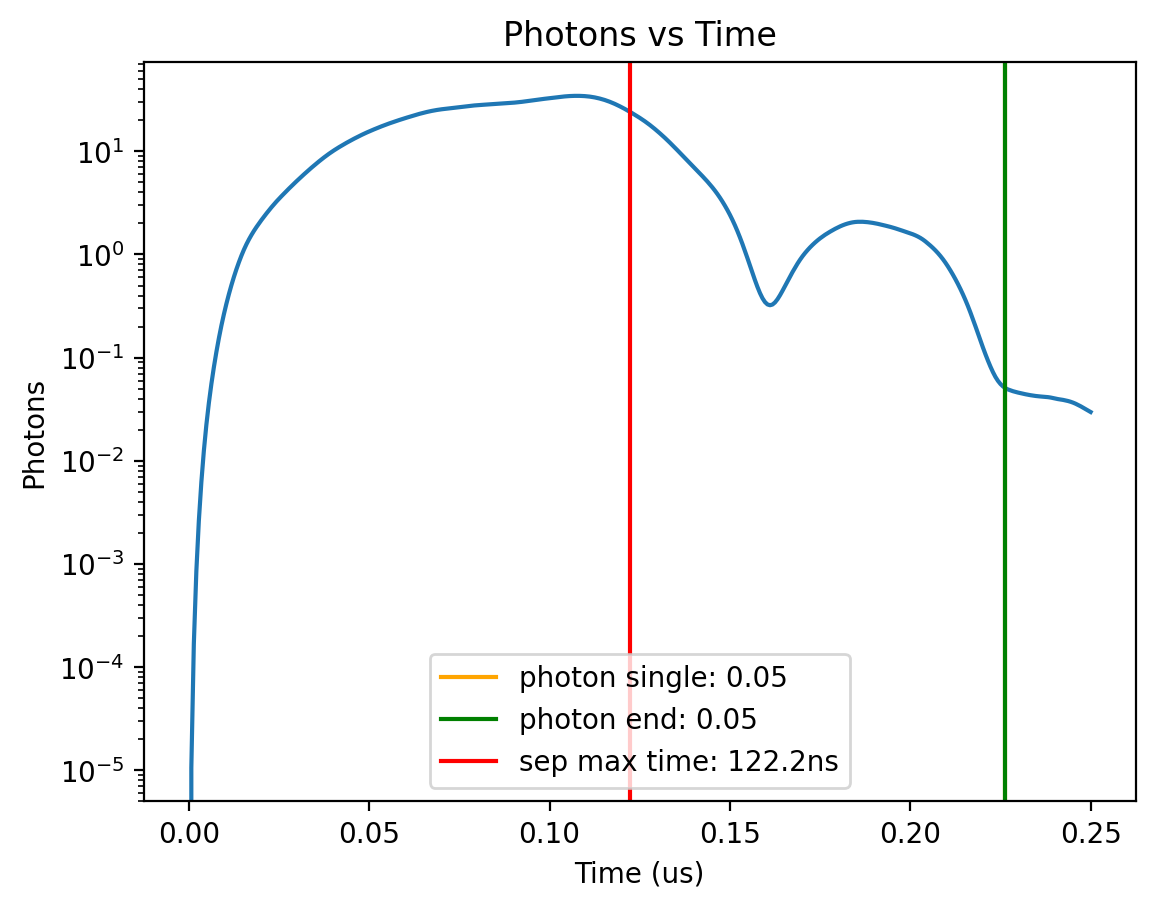

In [18]:
single_photon = b_higher_photons[0]

single_res = batched_res[0]
g_real, g_imag, e_real, e_imag = single_res.T
single_sep = jnp.sqrt((g_real - g_imag) ** 2 + (e_real - e_imag) ** 2)
single_sep = b_pf[0]

single_photon = g_real ** 2 + g_imag ** 2

ext = 50
ext_15 = -1
ext_2 = -1

s_photon = jnp.abs(single_photon - nR)

argmin = jnp.argmin(s_photon[ext:ext_2]) + ext
min_photon = single_photon[argmin]

argmin_2 = jnp.argmin(s_photon[ext:ext_15]) + ext
min_photon_2 = single_photon[argmin_2]

argmax = jnp.argmax(single_sep)

print(min_photon)
print(argmin)

print(min_photon_2)
print(argmin_2)

plt.plot(env.ts_sim, single_photon)
plt.axvline(x=env.ts_sim[argmin_2], label=f'photon single: {int(1e3*min_photon_2)/1e3}', color='orange')
plt.axvline(x=env.ts_sim[argmin], label=f'photon end: {int(1e3*min_photon)/1e3}', color='green')
plt.axvline(x=env.ts_sim[argmax], label=f'sep max time: {int(1e4*env.ts_sim[argmax])/1e1}ns', color='red')
plt.xlabel('Time (us)')
plt.ylabel('Photons')
plt.title('Photons vs Time')
plt.yscale('log')
plt.legend()
plt.show()

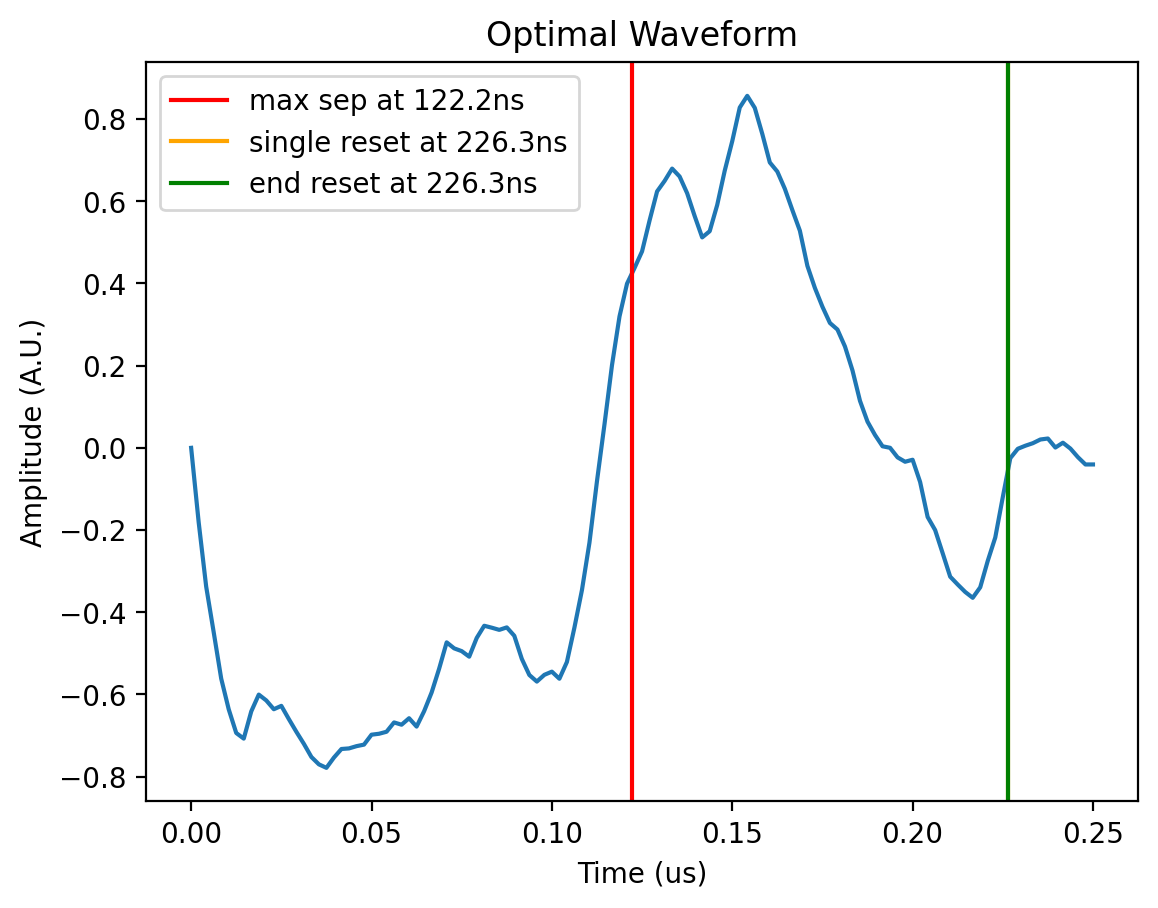

In [19]:
plt.plot(env.ts_action, action / env.mu / env.a0)
plt.axvline(x=env.ts_sim[argmax], label=f'max sep at {int(1e4*env.ts_sim[argmax])/1e1}ns', color='red')
plt.axvline(x=env.ts_sim[argmin_2], label=f'single reset at {int(1e4*env.ts_sim[argmin_2])/1e1}ns', color='orange')
plt.axvline(x=env.ts_sim[argmin], label=f'end reset at {int(1e4*env.ts_sim[argmin])/1e1}ns', color='green')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude (A.U.)')
plt.title('Optimal Waveform')
plt.legend()
plt.show()

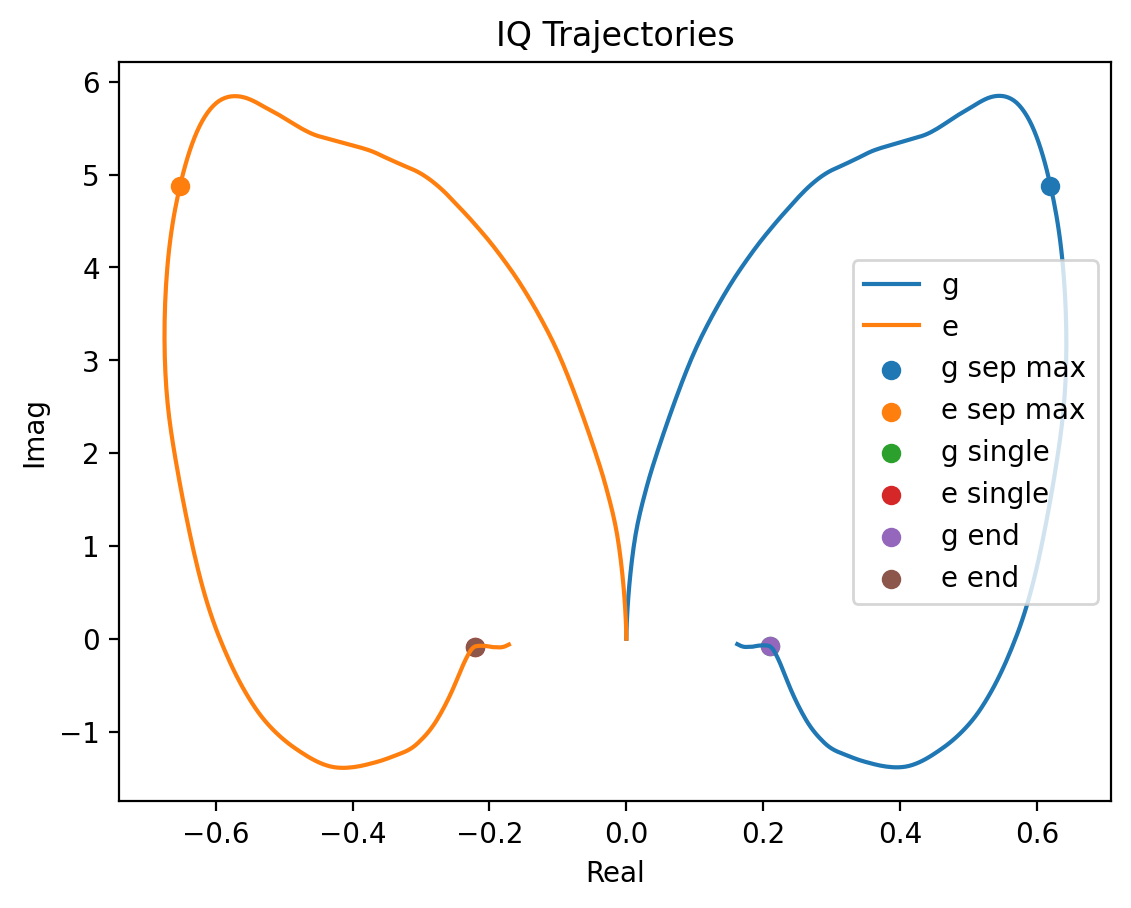

In [20]:
plt.plot(g_real, g_imag, label='g')
plt.plot(e_real, e_imag, label='e')
plt.scatter(g_real[argmax], g_imag[argmax], label='g sep max')
plt.scatter(e_real[argmax], e_imag[argmax], label='e sep max')
plt.scatter(g_real[argmin_2], g_imag[argmin_2], label='g single')
plt.scatter(e_real[argmin_2], e_imag[argmin_2], label='e single')
plt.scatter(g_real[argmin], g_imag[argmin], label='g end')
plt.scatter(e_real[argmin], e_imag[argmin], label='e end')
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title('IQ Trajectories')
plt.legend()
plt.show()

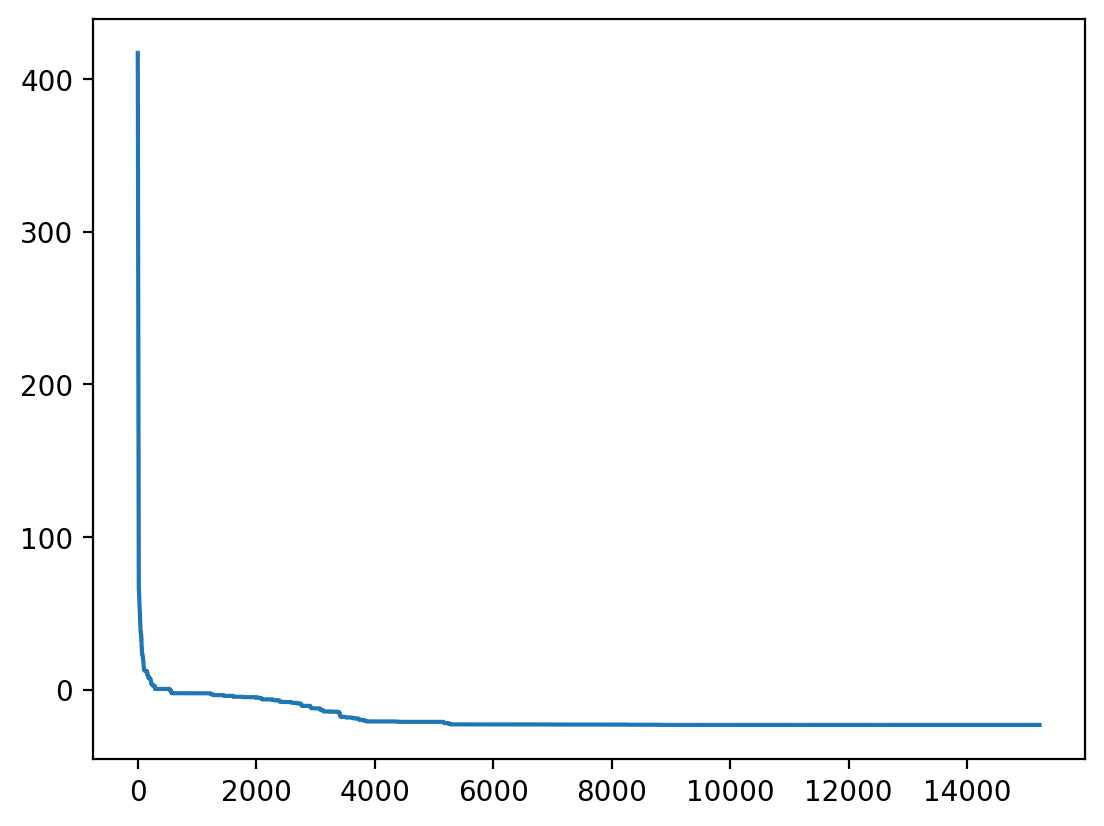

In [21]:
plt.plot(fitness_list)